In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: C:\Users\ALEX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## Load image

Let's load our favorite cats image on which we'll perform inference.

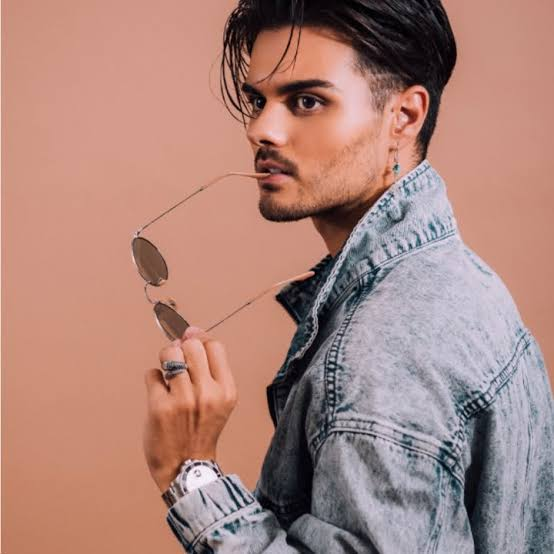

In [15]:
from PIL import Image
import requests

image_path = "input.jpeg"
image = Image.open(image_path)
image

## Prepare image and text prompts

We can prepare the image along with a text prompt for the model.

In [16]:
from transformers import GroundingDinoProcessor

processor = GroundingDinoProcessor.from_pretrained("IDEA-Research/grounding-dino-base")

As the Grounding DINO model was trained with a "." after each text, we'll do the same here.

In [41]:
text = "watch"

In [42]:
def preprocess_caption(caption: str) -> str:
    result = caption.lower().strip()
    if result.endswith("."):
        return result
    return result + "."

inputs = processor(images=image, text=preprocess_caption(text), return_tensors="pt")

## Load model

Let's load the model from the 🤗 hub. Do note that the authors [released](https://huggingface.co/models?other=grounding-dino) 2 checkpoints, a "tiny" and a "base" version.

In [43]:
from transformers import GroundingDinoForObjectDetection

model = GroundingDinoForObjectDetection.from_pretrained("IDEA-Research/grounding-dino-base")

## Forward pass

Let's perform a forward pass - we'll use the `torch.no_grad()` context manager as we don't need gradients to be computed at inference time, which saves us memory.

In [44]:
import torch

with torch.no_grad():
  outputs = model(**inputs)

## Visualize predictions

Let's visualize the results!

In [45]:
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, scores, labels, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax), c in zip(scores, labels, boxes, colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        label = f'{text}: {score:0.2f}'
        ax.text(xmin, ymin, label, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

In [46]:
# postprocess model outputs
width, height = image.size
postprocessed_outputs = processor.post_process_grounded_object_detection(outputs,
                                                                input_ids=inputs.input_ids,
                                                                target_sizes=[(height, width)],
                                                                box_threshold=0.3,
                                                                text_threshold=0.1)
results = postprocessed_outputs[0]

C:\Users\ALEX\AppData\Local\Temp\ipykernel_26196\2379675155.py:3: FutureWarning: `box_threshold` is deprecated and will be removed in version 4.51.0 for `GroundingDinoProcessor.post_process_grounded_object_detection`. Use `threshold` instead.
  postprocessed_outputs = processor.post_process_grounded_object_detection(outputs,


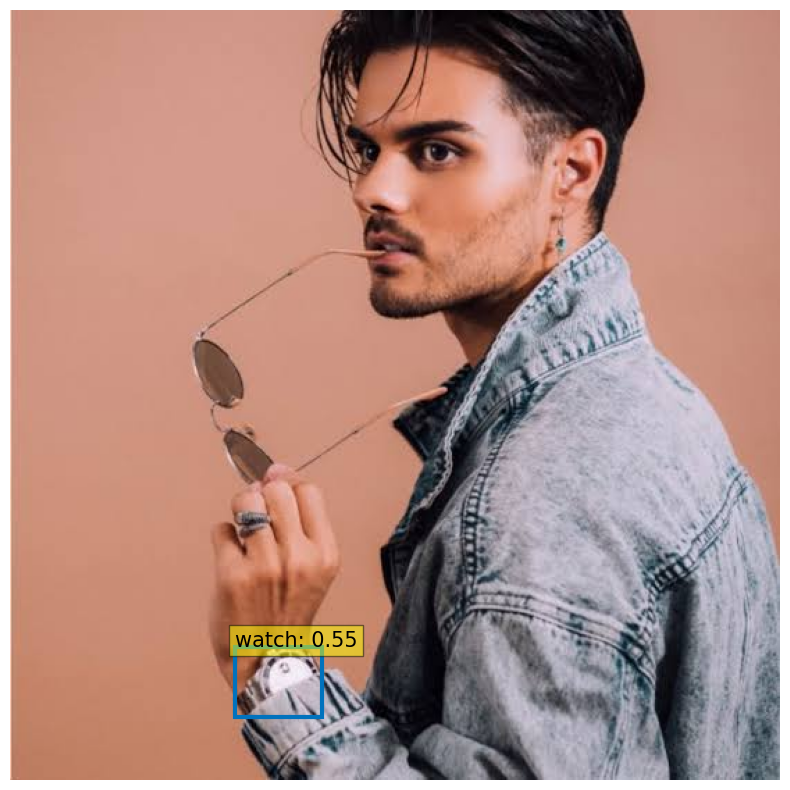

In [47]:
plot_results(image, results['scores'], results['labels'], results['boxes'])

In [48]:
print(results)

{'scores': tensor([0.5524]), 'boxes': tensor([[161.3548, 457.6638, 223.9829, 508.0650]]), 'text_labels': ['watch'], 'labels': ['watch']}
